# Biblical and Apocryphal Citations in Sermon Marginalia 

In [39]:
import sys
sys.path.append('../')
from lib.visualization import * 
from lib.dictionaries.authors import * 
from lib.standardization import * 
from collections import Counter
import pandas as pd
sermons_metadata = pd.read_csv("../assets/sermons.csv")
excluded = ['B07519','A87349','A30293', 'A30435'] # Welsh language or printed in 1701
sermons = sorted(sermons_metadata["id"]) # 4235 total 

In [6]:
import json
def get_tcpIDs(prefix): 
    return sorted([x for x in sermons if prefix in x])
with open(f'../assets/pre1660.json') as file:
    pre1660 = json.load(file)
preE,E,J,C,CW,IR = pre1660

In [ ]:
import pandas as pd
import re
citation_info = pd.read_csv("../outputs/citations.csv")

citations = {}
tcpIDs = citation_info['tcpID']
for idx, tcpID in enumerate(tcpIDs):
    if 'B' in tcpID: 
        prefix = 'B'
    else: 
        prefix = tcpID[:2]
    if tcpID not in pre1660[prefix]: continue
    
    if tcpID not in citations: 
        citations[tcpID] = [[],[]]
    else: 
        replaced = citation_info['citation'][idx].split(" ")
        if re.search(r'^he$|^am$|^time$|$the\^|^tyme$|^ti\^|^i\^|^Apol$|^ne$|^te$|^ti$|^tb$|^ac$|^child$',replaced[0]): continue

        decomposed = citation_info['decomposed'][idx]
        if isinstance(decomposed,float): continue
        decomposed = decomposed.split("; ")
        book = decomposed[0].split(" ")[0]
        if book == "Ibidem" and len(citations[tcpID][0]) > 0: 
            # address ibidem problem; still need to address the verse/ver problem 
            prior = citations[tcpID][0][-1].split(" ")
            if re.search(r"\d|\^",prior[0]): 
                book = prior[0] + " " + prior[1]
            else: 
                book = prior[0] 
            priornum = prior[1].split(".")
            for d, decomposed_citation in enumerate(decomposed):
                currnum = decomposed_citation.split(" ")[1]
                if len(priornum) == 2 and len(currnum.split(".")) == 1: 
                    decomposed[d] = f"{book} {priornum[1]}.{currnum}"
                else: 
                    decomposed[d] = f"{book} {currnum}"
        
        if re.search(r"^\w+ \d+ , \d+$",citation_info['citation'][idx]): 
            decomposed = [f"{decomposed[0]}.{decomposed[1].split(' ')[1]}"]
        citations[tcpID][0].extend(decomposed)
        locations = []
        if citation_info['marginal'][idx]: 
            location =  "marginal"
        else: location = "in-text"
        citations[tcpID][1].extend([location]*len(decomposed))

# Visualizations 

In [12]:
def get_citations(tcpIDs, loc="all"): 
    tcpIDs = {k:None for k in tcpIDs}
    all_books = {}
    all_chapters = {}
    all_verses = {}
    for tcpID,cited in citations.items(): 
        if tcpID not in tcpIDs: continue
        if len(cited[0]) == 0: continue
        if loc != "all" and cited[1][0] != loc:  
            continue
        cited = cited[0]
        for c in cited: 
            c = c.split(" ")
        
            if re.match(r'[\d\^]',c[0]): 
                # numbered book with unknown number
                if c[0] == '^':  
                    continue
                book = f"{c[0]} {c[1]}"
                ref = c[2]
            else: 
                book = c[0]
                ref = c[1]
            
            if book not in all_books: 
                all_books[book] = []
            all_books[book].append(tcpID)

            ref = ref.split(".")
            chapter = ref[0]
            if '*' not in chapter and "^" not in chapter: 
                key = f"{book} {chapter}"
                if key not in all_chapters: 
                    all_chapters[key] = []
                all_chapters[key].append(tcpID)
                if len(ref) == 2: 
                    verse = ref[1]
                    if '*' not in verse and "^" not in verse: 
                        key = f"{book} {chapter}.{verse}"
                        if key not in all_verses: 
                            all_verses[key] = []
                        all_verses[key].append(tcpID)
    return all_books, all_chapters, all_verses

In [ ]:
all_pre1660 = []
for prefix, id_list in pre1660.items(): 
    all_pre1660.extend(id_list)
b, c,v = get_citations(all_pre1660)

In [23]:
v_count = {}
for k, ver in v.items(): 
    k = k.split(" ")
    if k[0].isdigit():
        chap, verse = k[2].split(".")
        new_k = f"{k[0]}-{k[1]}-{chap}-{verse}"
    else: 
        chap, verse = k[1].split(".")
        new_k = f"{k[0]}-{chap}-{verse}"
    v_count[new_k] = len(ver)

In [25]:
with open('pre1660_citations.json','w+') as file: 
    json.dump(v_count,file)

In [19]:
sum([_ for _ in v_count.values()])

342275

In [38]:
import numpy as np
# Calculate percentiles
p = [50,60,75,80,85,90,95,99,99.5, 99.75, 99.99, 99.9999, 100]
percentiles = np.percentile([_ for _ in v_count.values()], p)

# Print the percentiles
for idx, percentile in enumerate(p): 
    print(f"{percentile}th percentile: {percentiles[idx]}")

50th percentile: 3.0
60th percentile: 5.0
75th percentile: 10.0
80th percentile: 13.0
85th percentile: 18.0
90th percentile: 26.0
95th percentile: 42.0
99th percentile: 86.37999999999738
99.5th percentile: 111.0
99.75th percentile: 140.0
99.99th percentile: 236.54379999999946
99.9999th percentile: 278.7557679999736
100th percentile: 280.0


In [17]:
def bar(orientation,data,title,color,labels,figx,figy):
    plt.figure(figsize = (figx, figy))
    if orientation == 'horizontal': 
        plt.barh(data[0],data[1],color=color)
    else: 
        plt.bar(data[0],data[1],color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(labels[0], fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel(labels[1], fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

In [24]:
aut = 'Fenner, William, 1600-1640'
all_books, all_chapters,all_verses = get_citations(['A41135'])

In [6]:
in_text_books, in_text_chapters,in_text_verses = get_citations(tcpIDs,"in-text")
marg_books, marg_chapters,marg_verses = get_citations(tcpIDs,"marginal")
all_books, all_chapters,all_verses = get_citations(tcpIDs)

In [ ]:
def visualize(title, color, labels, dictionary): 
    x,y = [],[]
    dictionary = {k:len(v) for k,v in dictionary.items() }
    print(sum(dictionary.values()))
    counts = sorted(dictionary.items(), key=lambda x:x[1],reverse=True)
    print(counts[:26])
    for word,freq in reversed(counts[:26]): 
        x.append(word)
        y.append(freq)
    bar('horizontal',(x,y),title,color,(labels[0],labels[1]),8,10)

# visualize('Most Commonly Cited Books in the Text','lightgrey',('Frequency','Book'),in_text_books)
# visualize('Most Commonly Cited Books in the Margin','lightgrey',('Frequency','Book'),marg_books)
# visualize('Most Commonly Cited Books','lightgrey',('Frequency','Book'),all_books)

# visualize('Most Commonly Cited Chapters','lightgrey',('Frequency','Chapter'),all_chapters)
# visualize('Most Commonly Cited Chapters in the Margin','lightgrey',('Frequency','Chapter'),marg_chapters)
# visualize('Most Commonly Cited Chapters in the Text','lightgrey',('Frequency','Chapter'),in_text_chapters)

visualize('Most Commonly Cited Verses','lightgrey',('Frequency','Verse'),all_verses)
# visualize('Most Commonly Cited Verses in the Margin','lightgrey',('Frequency','Verse'),in_text_verses)
# visualize('Most Commonly Cited Verses in the Text','lightgrey',('Frequency','Verse'),marg_verses)



In [ ]:
verse_counts = {k:len(v) for k,v in all_verses.items()}
print(verse_counts)

## Verse over time 

In [7]:
import numpy as np
dates = sermons_metadata["date"]
subjects = sermons_metadata["subject_headings"]
all_subjects = {}
titles = {}
orig_authors = {}
pubplace = {}
tcpID_dates = {}
for idx,s in enumerate(subjects): 
    tcpID = sermons_metadata['id'][idx]
    titles[tcpID] = sermons_metadata['title'][idx]
    orig_authors[tcpID] = sermons_metadata['authors'][idx]
    pubplace[tcpID] = sermons_metadata['pubplace'][idx]
    all_subjects[tcpID] = [_.strip('.') for _ in s.split("; ")]
    date = sermons_metadata['date'][idx]
    if "-" in date: 
        date = date.split("-")[0]
    tcpID_dates[tcpID] = date
    


In [16]:
def verse_over_time(verses):
    results = {}
    for tcpID, cited in citations.items(): 
        date = tcpID_dates[tcpID]
        locations = cited[1]
        decomposed = cited[0]
        for idx, citation in enumerate(decomposed): 
            if citation in verses: 
                if date not in results: 
                    results[date] = {}
                if tcpID not in results[date]: 
                    results[date][tcpID] = [] 
                results[date][tcpID].append(locations[idx])
    print(len(results))
    visualize_verse_over_time(verses, results) 
    return results

def visualize_verse_over_time(verses, results): 
    marg, text = [],[]
    sermons, years = [],[]
    for date in sorted(results): 
        marg_count, text_count = 0,0
        num_sermons = 0
        for tcpID, locations in results[date].items(): 
            num_sermons += 1 
            locations = Counter(locations)
            if "marginal" in locations: 
                marg_count += locations["marginal"]        
            if "in-text" in locations: 
                text_count += locations["in-text"]
        years.append(int(date))
        marg.append(marg_count)
        text.append(text_count)
        sermons.append(num_sermons)

    plt.figure(figsize = (15, 10))
    plt.bar(years,marg,color="lightgrey",label="Marginal")
    plt.bar(years,text,bottom=marg,color="darkgrey",label="In-Text")
    plt.scatter(years,sermons,color="black",label="Number of Books")
    if len(verses) <= 6: 
        plt.title(f"{', '.join(verses)}", fontsize=20)
    plt.xlabel("Publication Year", fontsize=15)
    plt.xticks(np.arange(min(years),max(years), 10.0), fontsize=12)
    plt.ylabel("Frequency", fontsize=15)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.show()

128


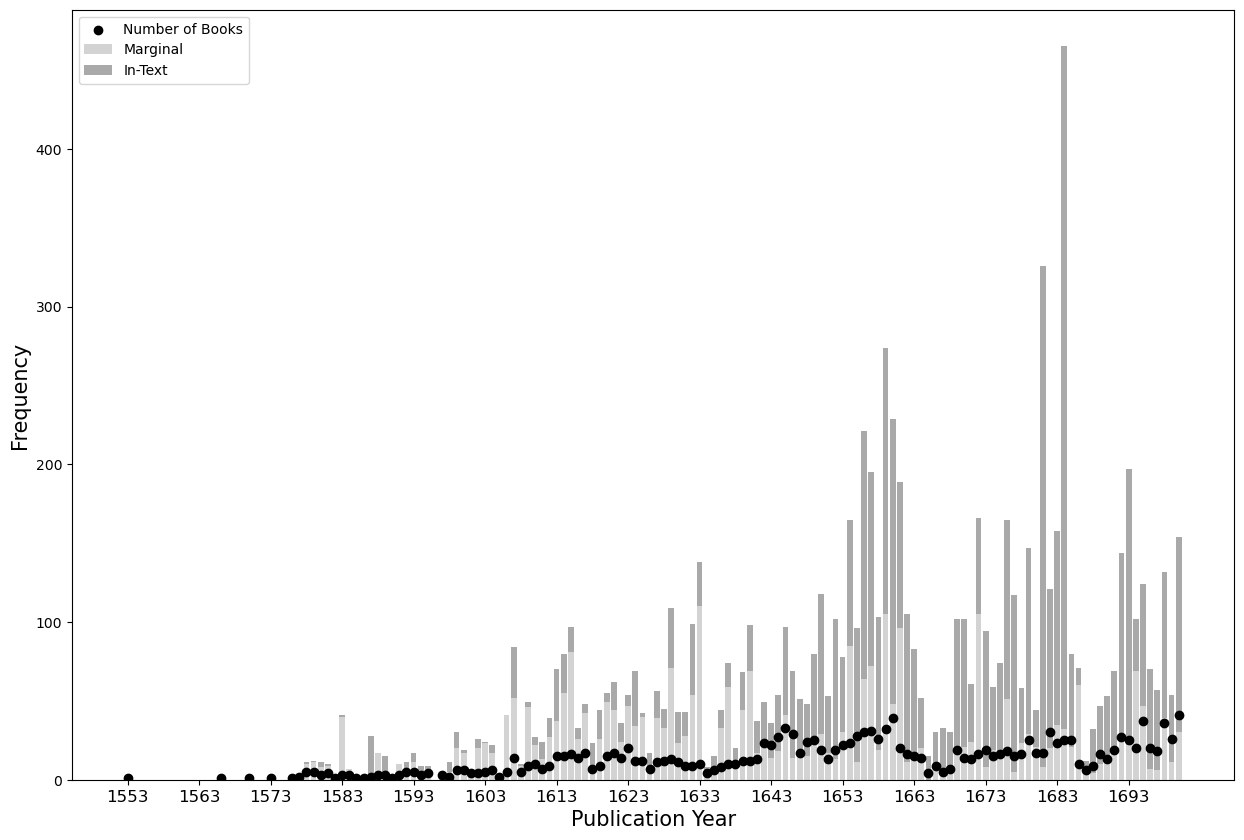

In [14]:
# verse_over_time(["Genesis 12.1"])
# results = verse_over_time(["Genesis 9.25"])
# verse_over_time(["Romans 8.28"])
# verse_over_time(["2 Timothy 3.16"])

# results = verse_over_time(["Genesis 2.18","Deuteronomy 24.1","Deuteronomy 24.2",
#                  "Matthew 5.31","Matthew 5.32","1 Corinthians 7.10"])
# verse_over_time(['Psalmss 137.9'])
# results = verse_over_time(["2 Corinthians 3.6"])
affections = ['Colossians 3.5', 'Colossians 3.5', 'Romans 8.13', 'Galatians 5.19', 'Galatians 5.20', 'Galatians 5.21', 'Galatians 5.24', '1 Corinthians 6.9', '1 Corinthians 6.10', 'Ephesians 5.3', 'Ephesians 5.4', 'Ephesians 5.5', 'Ephesians 5.6', 'Romans 6.13', '1 Peter 2.11', 'Ephesians 4.19', '2 Corinthians 12.21', 'Mark 7.21', 'Mark 7.22', 'Revelation 21.8', 'Romans 7.23', 'Matthew 15.19', 'Revelation 22.15', 'James 4.1', '1 Corinthians 6.13', 'Romans 6.6', 'Hebrews 13.4', 'Hebrews 12.16', '1 Thessalonians 4.3', '1 Corinthians 10.6', '1 Corinthians 10.7', '1 Corinthians 10.8', '1 Corinthians 5.1', 'Romans 7.5', 'Romans 1.29', 'Romans 1.26', '1 Thessalonians 4.5', '1 Corinthians 5.10', '1 Corinthians 5.11','Romans 8.6','Colossians 3.2','Colossians 3.2','Colossians 3.2', '1 John 2.15', '1 John 2.16', '1 John 2.17', '1 Chronicles 22.19', 'Colossians 3.1', 'Matthew 16.23', 'Romans 8.4', 'Romans 8.5', 'Romans 8.6', 'Matthew 6.19', 'Psalms 119.36', 'Psalms 119.37', 'Colossians 3.5', 'Philippians 3.19', 'Philippians 3.20', 'Luke 12.15', 'Psalms 62.10', 'Psalms 91.14', 'Luke 16.11', 'Philippians 1.23', 'Proverbs 23.5', '1 Chronicles 29.3', 'Luke 16.8', 'Luke 16.9', 'Psalms 49.11', 'Psalms 49.12', 'Psalms 49.13', 'Psalms 49.14', 'Psalms 49.15', 'Psalms 49.16', 'Psalms 49.17', 'Ecclesiastes 7.14', 'Luke 16.19', 'Luke 16.20', 'Luke 16.21', 'Luke 16.22', 'Luke 16.23', 'Luke 16.24', 'Luke 16.25']
results = verse_over_time(affections)

In [22]:
bible = {}
data = pd.read_csv("../assets/kjv.csv")
doc_id = data['doc_id']
text = data['text']
for idx, d_id in enumerate(doc_id): 
    d_id = re.sub(r" \(KJV\)| of the Apostles","",d_id)
    d_id = re.sub(":",".",d_id)
    bible[d_id] = text[idx]

124


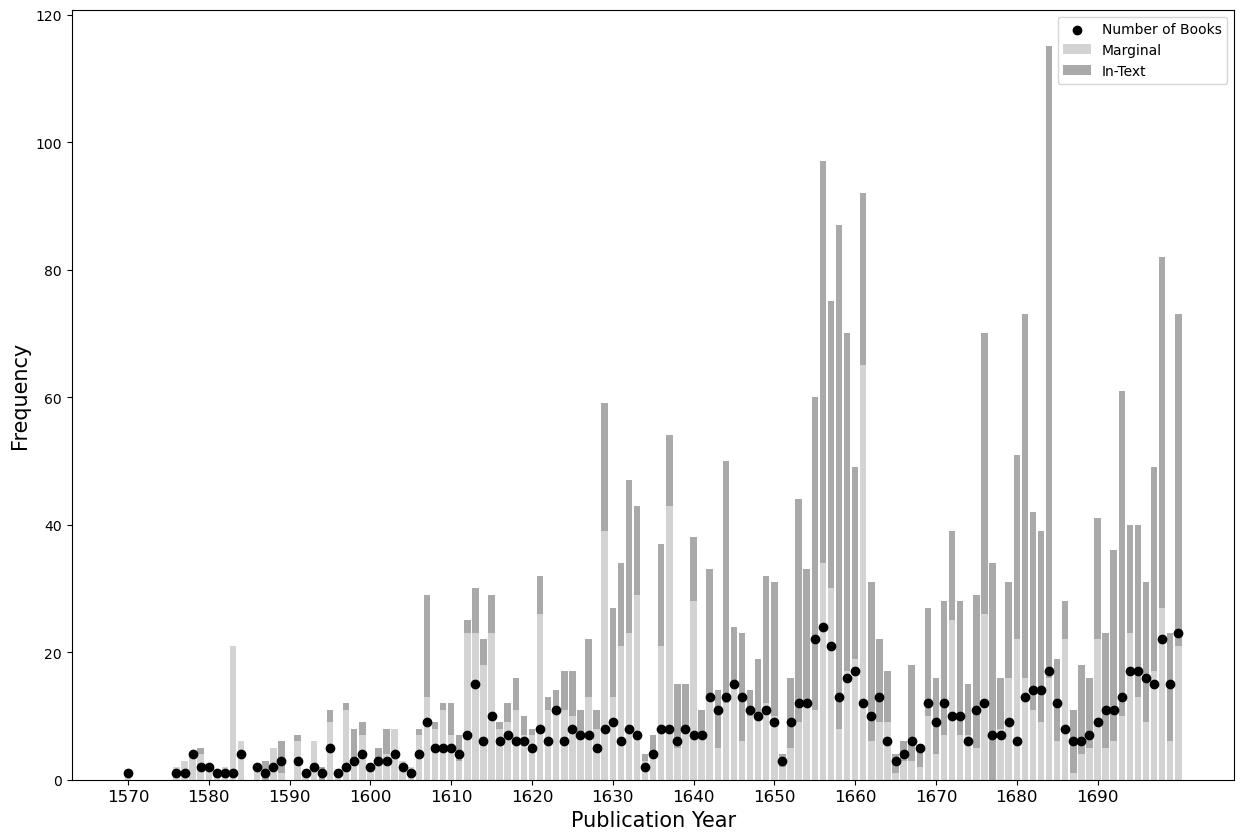

In [67]:
from lib.dictionaries.charity_citations import *
bible_charity = [re.sub(r":",".",x) for x in cited_dict['helping']]
bible_charity.extend([re.sub(r":",".",x) for x in cited_dict['punishment']])
bible_charity.extend([re.sub(r":",".",x) for x in cited_dict['godly']])
bible_charity = [x for x in bible_charity if x not in ['Matthew 25.41','Galatians 6.10','Luke 4.18','Hebrews 13.16',]]
results = verse_over_time(bible_charity)
# for verse in bible_charity: 
#     results = verse_over_time([verse])

117


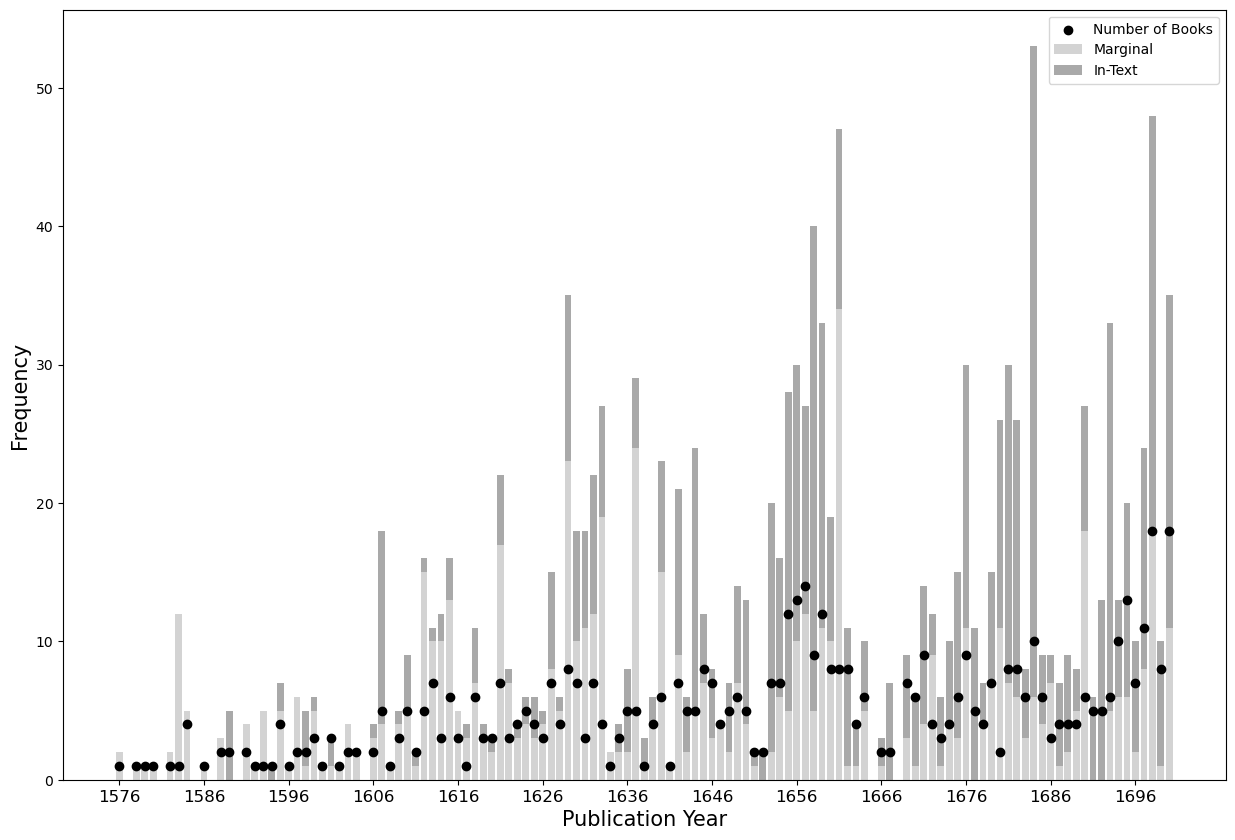

In [10]:

bible_charity = """Acts 2.45_ And sold their possessions and goods, and parted them to all men, as every man had need.
Matthew 19.21_ Jesus said unto him, If thou wilt be perfect, go and sell that thou hast, and give to the poor, and thou shalt have treasure in heaven: and come and follow me.
Deuteronomy 15.7_ If there be among you a poor man of one of thy brethren within any of thy gates in thy land which the LORD thy God giveth thee, thou shalt not harden thine heart, nor shut thine hand from thy poor brother:
Galatians 2.10_ Only they would that we should remember the poor; the same which I also was forward to do.
Isaiah 58.7_ Is it not to deal thy bread to the hungry, and that thou bring the poor that are cast out to thy house? when thou seest the naked, that thou cover him; and that thou hide not thyself from thine own flesh?
James 2.15_ If a brother or sister be naked, and destitute of daily food,
James 2.16_ And one of you say unto them, Depart in peace, be ye warmed and filled; notwithstanding ye give them not those things which are needful to the body; what doth it profit?
Job 29.12_ Because I delivered the poor that cried, and the fatherless, and him that had none to help him.
Luke 11.41_ But rather give alms of such things as ye have; and, behold, all things are clean unto you.
Luke 12.33_ Sell that ye have, and give alms; provide yourselves bags which wax not old, a treasure in the heavens that faileth not, where no thief approacheth, neither moth corrupteth.
Luke 14.12_ Then said he also to him that bade him, When thou makest a dinner or a supper, call not thy friends, nor thy brethren, neither thy kinsmen, nor thy rich neighbours; lest they also bid thee again, and a recompence be made thee.
Matthew 25.35_ For I was an hungred, and ye gave me meat: I was thirsty, and ye gave me drink: I was a stranger, and ye took me in:
Romans 12.13_ Distributing to the necessity of saints; given to hospitality.
1 John 3.17_ But whoso hath this world's good, and seeth his brother have need, and shutteth up his bowels of compassion from him, how dwelleth the love of God in him?
1 Corinthians 16.1_ Now concerning the collection for the saints, as I have given order to the churches of Galatia, even so do ye.
Proverbs 3.28_ Say not unto thy neighbour, Go, and come again, and to morrow I will give; when thou hast it by thee.
Acts 11.29_ Then the disciples, every man according to his ability, determined to send relief unto the brethren which dwelt in Judaea:
Acts 11.30_ Which also they did, and sent it to the elders by the hands of Barnabas and Saul.
Matthew 25.42_ For I was an hungred, and ye gave me no meat: I was thirsty, and ye gave me no drink:
Proverbs 21.13_ Whoso stoppeth his ears at the cry of the poor, he also shall cry himself, but shall not be heard.
Matthew 25.43_ I was a stranger, and ye took me not in: naked, and ye clothed me not: sick, and in prison, and ye visited me not.
Ezekiel 16.49_ Behold, this was the iniquity of thy sister Sodom, pride, fulness of bread, and abundance of idleness was in her and in her daughters, neither did she strengthen the hand of the poor and needy.
Job 31.22_ Then let mine arm fall from my shoulder blade, and mine arm be broken from the bone.
Proverbs 17.5_ Whoso mocketh the poor reproacheth his Maker: and he that is glad at calamities shall not be unpunished.
Acts 10.2_ A devout man, and one that feared God with all his house, which gave much alms to the people, and prayed to God alway.
Proverbs 14.31_ He that oppresseth the poor reproacheth his Maker: but he that honoureth him hath mercy on the poor.
Proverbs 19.17_ He that hath pity upon the poor lendeth unto the LORD; and that which he hath given will he pay him again.
Proverbs 11.24_ There is that scattereth, and yet increaseth; and there is that withholdeth more than is meet, but it tendeth to poverty.
Acts 20.35_ I have shewed you all things, how that so labouring ye ought to support the weak, and to remember the words of the Lord Jesus, how he said, It is more blessed to give than to receive.
2 Corinthians 9.6_ But this I say, He which soweth sparingly shall reap also sparingly; and he which soweth bountifully shall reap also bountifully.
2 Corinthians 9.7_ Every man according as he purposeth in his heart, so let him give; not grudgingly, or of necessity: for God loveth a cheerful giver.
2 Corinthians 9.9_ (As it is written, He hath dispersed abroad; he hath given to the poor: his righteousness remaineth for ever.
2 Corinthians 9.12 For the administration of this service not only supplieth the want of the saints, but is abundant also by many thanksgivings unto God;"""
bible_charity = [x.split("_")[0] for x in bible_charity.split("\n")]
# print(bible_charity)
results = verse_over_time(bible_charity)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_cluster(df,num, tcpIDs,t):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    model = KMeans(n_clusters=num) 
    label = model.fit_predict(pca_results) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(label,tcpIDs):
        kmeans_groups[k].append(v)
    groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred',5:'darkgreen'}
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
    plt.legend()
    plt.title(t,fontsize = 10)
    plt.figure(figsize=(20,20))
    plt.show()

    return kmeans_groups

In [14]:
x, y = [],[]
for tcpID, c_info in citations.items(): 
    x.append(tcpID)
    c = c_info[0]
    c = " ".join(["_".join(x.split(" ")) for x in c if "." in x.split(" ")[1]])
    y.append(c)

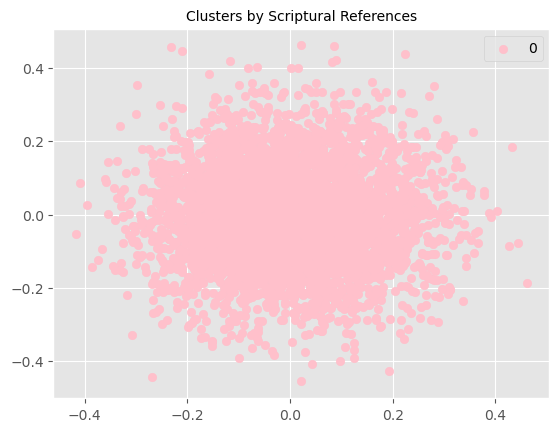

<Figure size 2000x2000 with 0 Axes>

In [15]:
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
results = vector.fit_transform(x)
df = pd.DataFrame(results.toarray(), index=y, columns=vector.get_feature_names_out()) 
groups = pca_cluster(df,1,x,'Clusters by Scriptural References')

In [20]:
tcpIDs = []
for date, dictionary in results.items(): 
    tcpIDs.extend(dictionary.keys())
subjects = []
exclude = ['Sermons, English','17th century','Sermons','Bible','Early works to 1800','16th century']
for tcpID in tcpIDs: 
    for s in all_subjects[tcpID]: 
        if s not in exclude: 
            subjects.append(s)
print(Counter(subjects).most_common(n=21))

[('N.T', 130), ('O.T', 92), ('Funeral sermons', 52), ('Church of England', 49), ('England', 20), ('Christian life', 20), ('Commentaries', 19), ('Fast-day sermons', 19), ('God', 13), ('Great Britain', 11), ('History', 11), ('Jesus Christ', 11), ('Controversial literature', 9), ('Sermons, American', 9), ('Faith', 7), ('Charity', 7), ('Catholic Church', 6), ('No Keywords', 6), ('Religious aspects', 6), ('Christianity', 6), ("Lord's prayer", 5)]


In [55]:
dictionary = {}
for date,item in results.items(): 
    for key, value in item.items(): 
        dictionary[key] = len(value)
# dictionary = {k:len(v) for k,v in results.items()}
print(sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:11])

[('A51846', 67), ('A25470', 48), ('A51840', 40), ('A19625', 33), ('A51842', 33), ('A25478', 31), ('A91945', 31), ('A57152', 29), ('A34992', 26), ('A91907', 24), ('B27417', 23)]


In [13]:
tcpID_aut = {}
for aut,id_list in aut_tcpIDs.items(): 
    for tcpID in id_list: 
        if tcpID not in tcpID_aut: 
            tcpID_aut[tcpID] = []
        if aut not in tcpID_aut[tcpID]:
            tcpID_aut[tcpID].append(aut)

In [ ]:
results['1684']['A51846']

In [14]:
tcpIDs = citations.keys()
# target_date = '1684'
# for date, dictionary in results.items(): 
#     if date == target_date:
#         tcpIDs.extend(dictionary.keys())

subjects = []
aut = []
pub = []
exclude = ['Sermons, English','17th century','Sermons','Bible','Early works to 1800','16th century']
verses = [] 
for tcpID in tcpIDs: 
    # print(pubplace[tcpID],tcpID_aut[tcpID],titles[tcpID],all_subjects[tcpID])
    for c in citations[tcpID][0]: 
        if c in bible_charity: 
            verses.append(c)
            aut.extend(tcpID_aut[tcpID])
            pub.append(pubplace[tcpID])
    # print(tcpID, verses)
# print(count)
#     for s in all_subjects[tcpID]: 
#         if s not in exclude: 
#             subjects.append(s)
# print(Counter(subjects).most_common())

In [11]:
def visualize(title, color, labels, dictionary): 
    x,y = [],[]
    print(sum(dictionary.values()))
    counts = sorted(dictionary.items(), key=lambda x:x[1],reverse=True)
    print(counts[:10])
    for word,freq in reversed(counts[:10]): 
        x.append(word)
        y.append(freq)
    bar('horizontal',(x,y),title,color,(labels[0],labels[1]),8,5)

1784
[('Manton, Thomas, 1620-1677', 78), ('Annesley, Samuel, 1620?-1696', 57), ('Tillotson, John, 1630-1694', 44), ('Andrewes, Lancelot, 1555-1626', 23), ('Reynolds, Edward, 1599-1676', 23), ('Featley, Daniel, 1582-1645', 21), ('Gataker, Thomas, 1574-1654', 20), ('Bates, William, 1625-1699', 19), ('Barrow, Isaac, 1630-1677', 19), ('Laud, William, 1573-1645', 18)]


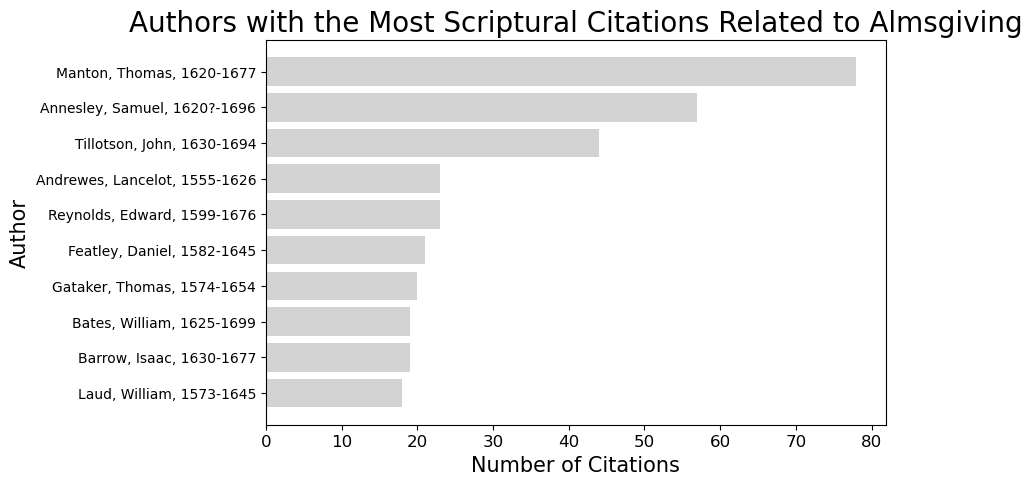

In [18]:
visualize('Authors with the Most Scriptural Citations Related to Almsgiving','lightgrey',('Number of Citations','Author'),Counter(aut))

1436
[('Matthew 25.35', 102), ('Isaiah 58.7', 100), ('Proverbs 19.17', 88), ('2 Corinthians 9.7', 84), ('2 Corinthians 9.6', 77), ('1 John 3.17', 73), ('Ezekiel 16.49', 72), ('Luke 12.33', 71), ('Matthew 19.21', 64), ('James 2.16', 61)]


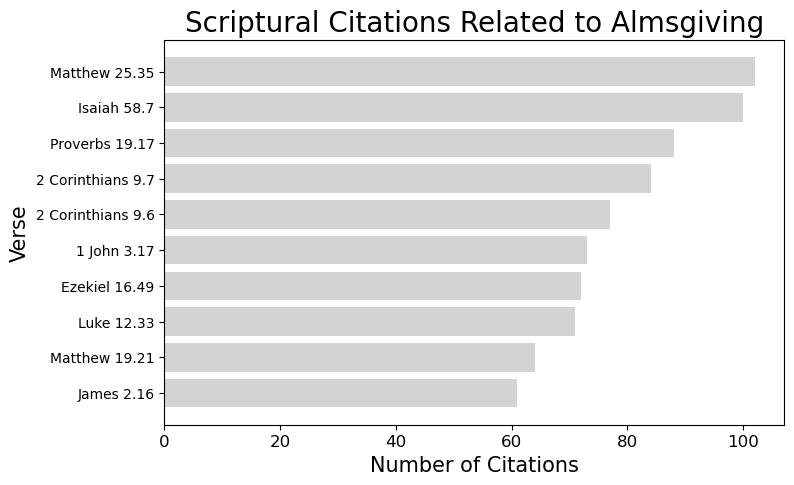

In [19]:
visualize('Scriptural Citations Related to Almsgiving','lightgrey',('Number of Citations','Verse'),Counter(verses))

In [26]:
for verse in Counter(verses).most_common(n=5): 
    print(verse, bible[verse[0]])

('Matthew 25.35', 102) For I was an hungred, and ye gave me meat: I was thirsty, and ye gave me drink: I was a stranger, and ye took me in:
('Isaiah 58.7', 100) Is it not to deal thy bread to the hungry, and that thou bring the poor that are cast out to thy house? when thou seest the naked, that thou cover him; and that thou hide not thyself from thine own flesh?
('Proverbs 19.17', 88) He that hath pity upon the poor lendeth unto the LORD; and that which he hath given will he pay him again.
('2 Corinthians 9.7', 84) Every man according as he purposeth in his heart, so let him give; not grudgingly, or of necessity: for God loveth a cheerful giver.
('2 Corinthians 9.6', 77) But this I say, He which soweth sparingly shall reap also sparingly; and he which soweth bountifully shall reap also bountifully.


In [33]:
special_aut = set(aut_tcpIDs["Andrewes, Lancelot, 1555-1626"])

In [50]:
import json
for tcpID in special_aut: 
    with open(f'../assets/encoded/{tcpID}.json','r') as file:
        text,info = json.load(file)
    c_count = 0
    output = []
    for s, sentence in enumerate(text):
        found = False
        verses = [] 
        s_idx, t_idx, is_note, encodings, citations, outliers, replaced = sentence 
        s_idx = str(s_idx)
        sermon, paragraph = info[s_idx][0], info[s_idx][2]
        for c_idx, c in citations.items(): 
            rep = replaced[int(c_idx)]
            if re.search(r'^he$|^am$|^time$|$the\^|^tyme$|^ti\^|^i\^|^Apol$|^ne$|^te$|^ti$|^tb$|^ac$',rep.split(" ")[0]): continue
            if re.search(r"^\w+ \d+ , \d+$",rep): 
                c = [f"{c[0]}.{c[1].split(' ')[1]}"]
        
            c_count += len(c)
            for item in c: 
                if item in bible_charity: 
                    verses.append(item)
                    found = True 
        if found: 
            # print(tcpID)
            print(tcpID_aut[tcpID],titles[tcpID],all_subjects[tcpID])
            print(verses)
            if is_note: 
                print('context of marginal note:'," ".join([x[0] for x in text[s-1][3]]))
            print('sentence with citation:'," ".join([x[0] for x in encodings]))  
            if is_note: 
                print('context:'," ".join([x[0] for x in text[s+1][3]]))

            print('\n')

['Andrewes, Lancelot, 1555-1626'] Scala cœli Nineteen sermons concerning prayer. The first sixe guiding to the true doore: the residue teaching how so to knocke thereat that wee may enter. The former part containing a preparation to prayer, the latter an exposition vpon the seuerall petitions of the Lords prayer. ["Lord's prayer", 'Sermons', 'Prayer', 'Sermons', 'Sermons, English', '17th century']
['Isaiah 58.7']
sentence with citation: Prou. 1 6. with mercy and faithfulnesse sinnes are forgiuen. Isa. 58. 7. Dan. 4. 27. and Luk. 11. Date Eleemosina , & omnia sunt munda.


['Andrewes, Lancelot, 1555-1626'] Apospasmatia sacra, or, A collection of posthumous and orphan lectures delivered at St. Pauls and St. Giles his church / by the Right Honourable and Reverend Father in God, Lancelot Andrews ... ['Church of England', 'Sermons', 'Bible', 'O.T', 'Genesis I-IV', 'Sermons', 'Sermons, English']
['Matthew 19.21', 'Proverbs 19.17']
sentence with citation: But we must remember that many things